# dual_autodiff: Forward-Mode Automatic Differentiation

This notebook demonstrates the `dual_autodiff` package and its capabilities. We will:
1. Perform basic arithmetic and compute derivatives using the `Dual` class.
2. Compare derivatives calculated using:
   - Analytical methods.
   - Numerical methods (finite differences).
   - Dual numbers.
3. Analyze the errors in numerical methods.
4. Compare the performance of the Python and Cythonized implementations.

### Theory: Dual Numbers
Dual numbers are of the form:
$$ x = a + b\epsilon, \quad \text{where } \epsilon^2 = 0. $$

Using dual numbers, the derivative of a function \( f(x) \) can be computed as:
$$ f(a + b\epsilon) = f(a) + f'(a)b\epsilon, $$
where:
- \( f(a) \): Value of the function.
- \( f'(a) \): Derivative of the function.

This eliminates the need for finite differences and avoids numerical instabilities.


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from dual_autodiff.dual import Dual

# Non-vectorized tests
print("=== Non-Vectorized Operations ===")
x = Dual(2, 1)
y = Dual(3, 2)

# Basic Arithmetic
print(f"x: {x}")  # Dual(real=2, dual=1)
print(f"y: {y}")  # Dual(real=3, dual=2)
print(f"x + y: {x + y}")  # Dual(real=5, dual=3)
print(f"x - y: {x - y}")  # Dual(real=-1, dual=-1)
print(f"x * y: {x * y}")  # Dual(real=6, dual=7)
print(f"x / y: {x / y}")  # Dual(real=0.6667, dual=0.1111)

# Trigonometric Functions
print(f"x.sin(): {x.sin()}")  # Dual(real=sin(2), dual=cos(2))
print(f"x.cos(): {x.cos()}")  # Dual(real=cos(2), dual=-sin(2))
print(f"x.tan(): {x.tan()}")  # Dual(real=tan(2), dual=1/cos^2(2))

# Exponential and Logarithmic Functions
print(f"x.exp(): {x.exp()}")  # Dual(real=exp(2), dual=exp(2))
print(f"x.log(): {x.log()}")  # Dual(real=log(2), dual=1/2)

# Composite Functions
f = (x ** 2).sin() + x.exp()
print(f"Composite Function (sin(x^2) + exp(x)): {f}")  # Dual(real=?, dual=?)

print("\n")

# Vectorized tests
print("=== Vectorized Operations ===")
arr = np.array([Dual(1, 1), Dual(2, 1), Dual(3, 1)])

# Element-wise Arithmetic
print(f"arr: {arr}")
print(f"arr + 2: {arr + 2}")
print(f"arr * 2: {arr * 2}")

# Element-wise Trigonometric Functions
print(f"np.sin(arr): {np.sin(arr)}")  # Element-wise sine
print(f"np.cos(arr): {np.cos(arr)}")  # Element-wise cosine
print(f"np.tan(arr): {np.tan(arr)}")  # Element-wise tangent

# Element-wise Exponential and Logarithmic Functions
print(f"np.exp(arr): {np.exp(arr)}")  # Element-wise exponential
print(f"np.log(arr): {np.log(arr)}")  # Element-wise logarithm

# Composite Function (Vectorized)
f_vec = np.sin(arr ** 2) + np.exp(arr)
print(f"Composite Function (sin(arr^2) + exp(arr)): {f_vec}")



=== Non-Vectorized Operations ===
x: 2 + 1ε
y: 3 + 2ε
x + y: 5 + 3ε
x - y: -1 + -1ε
x * y: 6 + 7ε
x / y: 0.6666666666666666 + -0.1111111111111111ε
x.sin(): 0.9092974268256817 + -0.4161468365471424ε
x.cos(): -0.4161468365471424 + -0.9092974268256817ε
x.tan(): -2.185039863261519 + 5.774399204041917ε
x.exp(): 7.38905609893065 + 7.38905609893065ε
x.log(): 0.6931471805599453 + 0.5ε
Composite Function (sin(x^2) + exp(x)): 6.632253603622722 + 4.774481615476203ε


=== Vectorized Operations ===
arr: [Dual(1, 1) Dual(2, 1) Dual(3, 1)]
arr + 2: [Dual(3, 1) Dual(4, 1) Dual(5, 1)]
arr * 2: [Dual(2, 2) Dual(4, 2) Dual(6, 2)]
np.sin(arr): [Dual(0.8414709848078965, 0.5403023058681398)
 Dual(0.9092974268256817, -0.4161468365471424)
 Dual(0.1411200080598672, -0.9899924966004454)]
np.cos(arr): [Dual(0.5403023058681398, -0.8414709848078965)
 Dual(-0.4161468365471424, -0.9092974268256817)
 Dual(-0.9899924966004454, -0.1411200080598672)]
np.tan(arr): [Dual(1.557407724654902, 3.425518820814759)
 Dual(-2.1850

## Basic Arithmetic and Trigonometric Operations

Here, we demonstrate basic arithmetic (addition, subtraction, multiplication, division) and trigonometric/logarithmic operations using the `Dual` class.


In [2]:
# Basic operations
x = Dual(3, 1)
y = Dual(2, 1)

# Arithmetic operations
print(f"x + y = {x + y}")
print(f"x - y = {x - y}")
print(f"x * y = {x * y}")
print(f"x / y = {x / y}")

# Trigonometric and logarithmic functions

print(f"sin(y) = {y.sin()}")
print(f"cos(y) = {y.cos()}")
print(f"log(y) = {y.log()}")
print(f"exp(y) = {y.exp()}")


x + y = 5 + 2ε
x - y = 1 + 0ε
x * y = 6 + 5ε
x / y = 1.5 + -0.25ε
sin(y) = 0.9092974268256817 + -0.4161468365471424ε
cos(y) = -0.4161468365471424 + -0.9092974268256817ε
log(y) = 0.6931471805599453 + 0.5ε
exp(y) = 7.38905609893065 + 7.38905609893065ε


# Derivatives

We aim to compute the derivative of the function:

$$
f(x) = \ln(\sin(x)) + x^2 \cos(x)
$$

at \( x = 1.5 \), using three different methods:

1. **Analytical Derivative**: Derived using calculus.
2. **Numerical Derivative**: Using finite differences.
3. **Dual Numbers**: Automatic differentiation.

We will compare the results and discuss the accuracy of each method.


In [3]:
import numpy as np
from dual_autodiff.dual import Dual

# Define the function f(x)
def f(x):
    if isinstance(x, Dual):
        return x.sin().log() + (x**2) * x.cos()
    else:
        return np.log(np.sin(x)) + (x**2) * np.cos(x)

# Analytical first derivative
def analytical_derivative(x):
    return (1 / np.sin(x)) * np.cos(x) + 2 * x * np.cos(x) - x**2 * np.sin(x)

# Analytical second derivative
def analytical_second_derivative(x):
    return (-np.cos(x) / (np.sin(x)**2)) + 2 * np.cos(x) - 4 * x * np.sin(x) - x**2 * np.cos(x)

# Numerical derivative (finite differences)
def numerical_derivative(func, x, h=1e-5):
    return (func(x + h) - func(x - h)) / (2 * h)

# Dual number derivative
def dual_derivative(x):
    return f(Dual(x, 1)).dual

# Compute derivatives at x = 1.5
x = 1.5
analytical_result = analytical_derivative(x)
second_analytical_result = analytical_second_derivative(x)
numerical_result = numerical_derivative(f, x)
dual_result = dual_derivative(x)

# Print results
print(f"Analytical First Derivative at x={x}: {analytical_result}")
print(f"Analytical Second Derivative at x={x}: {second_analytical_result}")
print(f"Numerical Derivative at x={x}: {numerical_result}")
print(f"Dual Numbers Derivative at x={x}: {dual_result}")


Analytical First Derivative at x=1.5: -1.9612372705533612
Analytical Second Derivative at x=1.5: -6.073747153093557
Numerical Derivative at x=1.5: -1.9612372706409584
Dual Numbers Derivative at x=1.5: -1.9612372705533612


# Error Analysis of Derivative Methods

In this section, we analyze the **errors** in derivative calculations using three methods:
1. **Analytical Method:** The derivative is calculated using calculus.
2. **Numerical Method:** Finite difference approximations with step size \( h \).
3. **Dual Numbers Method:** Forward-mode automatic differentiation using dual numbers.

We will:
- Visualize the function \( f(x) = \ln(\sin(x)) + x^2 \cdot \cos(x) \) over a specified range of \( x \).
- Compare the **errors** between:
  - Analytical and numerical derivatives.
  - Dual and numerical derivatives.
- Visualize the **numerical error** as a function of step size \( h \) and point of evaluation \( x \).

These analyses demonstrate the advantages of using dual numbers for derivative computations and highlight the sensitivity of numerical methods to the choice of \( h \).


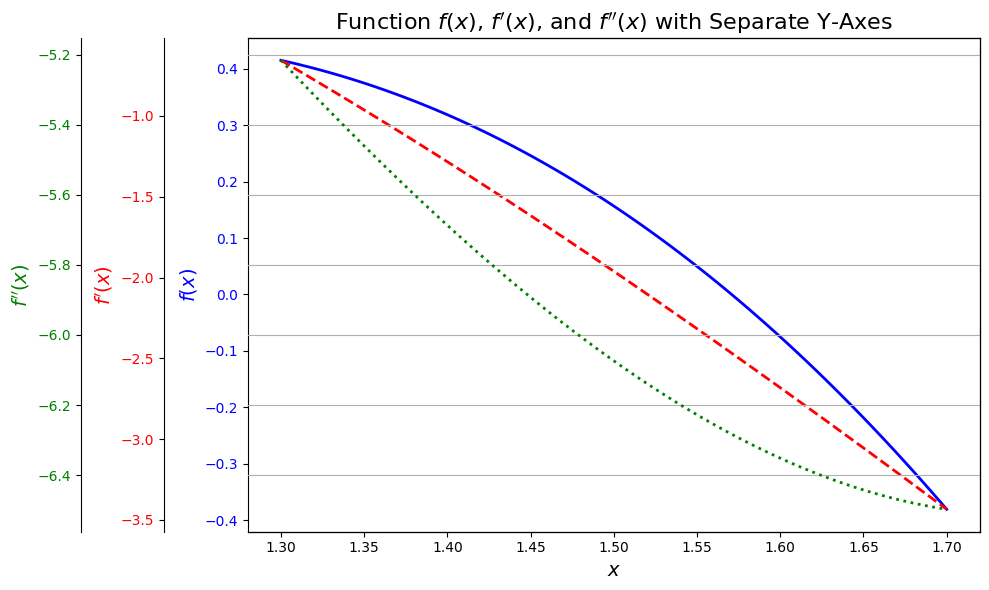

In [4]:
# Define the range for x
x_range = np.linspace(1.3, 1.7, 100)  # Focused range to avoid log errors

# Compute values for f(x), f'(x), and f''(x)
f_values = [f(x) for x in x_range]
f_prime_values = [analytical_derivative(x) for x in x_range]
f_double_prime_values = [analytical_second_derivative(x) for x in x_range]

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot f(x) on the primary y-axis
ax1.plot(x_range, f_values, label="$f(x)$", color="blue", linewidth=2)
ax1.set_ylabel("$f(x)$", fontsize=14, color="blue")
ax1.tick_params(axis="y", labelcolor="blue")
ax1.set_xlabel("$x$", fontsize=14)
ax1.set_title("Function $f(x)$, $f'(x)$, and $f''(x)$ with Separate Y-Axes", fontsize=16)

# Add a second y-axis for f'(x)
ax2 = ax1.twinx()
ax2.spines["left"].set_position(("outward", 60))  # Offset the second y-axis to the left
ax2.plot(x_range, f_prime_values, label="$f'(x)$ (First Derivative)", color="red", linestyle="--", linewidth=2)
ax2.set_ylabel("$f'(x)$", fontsize=14, color="red")
ax2.tick_params(axis="y", labelcolor="red")
ax2.spines["left"].set_visible(True)

# Add a third y-axis for f''(x)
ax3 = ax1.twinx()
ax3.spines["left"].set_position(("outward", 120))  # Offset the third y-axis further left
ax3.plot(x_range, f_double_prime_values, label="$f''(x)$ (Second Derivative)", color="green", linestyle=":", linewidth=2)
ax3.set_ylabel("$f''(x)$", fontsize=14, color="green")
ax3.tick_params(axis="y", labelcolor="green")
ax3.spines["left"].set_visible(True)

# Adjust positions of the spines for better alignment
ax2.yaxis.set_label_position("left")
ax2.yaxis.set_ticks_position("left")
ax3.yaxis.set_label_position("left")
ax3.yaxis.set_ticks_position("left")

# Combine legends for all three axes and place it outside the plot
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()


plt.grid(True)
plt.tight_layout()
plt.show()


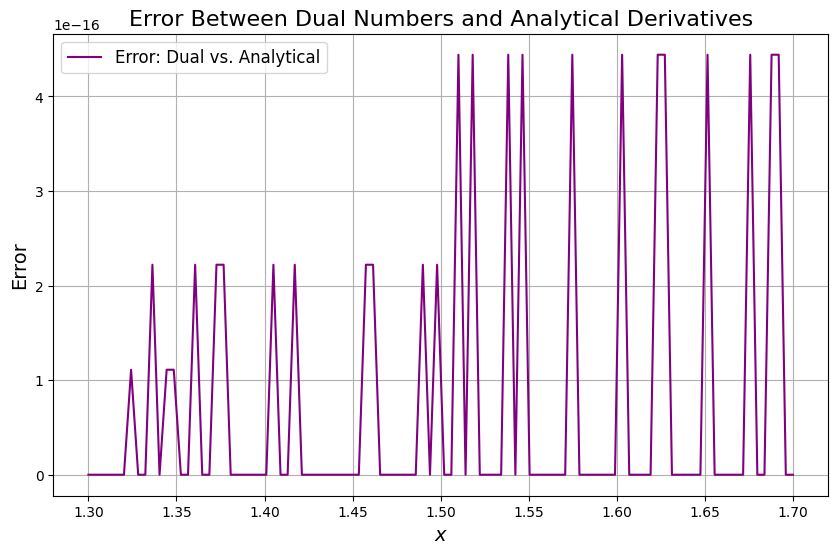

In [15]:
# Compute error between dual and analytical derivatives
error_dual_analytical = np.abs(np.array(f_prime_values) - np.array([dual_derivative(x) for x in x_range]))

# Plot the error
plt.figure(figsize=(10, 6))
plt.plot(x_range, error_dual_analytical, label="Error: Dual vs. Analytical", color="purple", linestyle="-")
plt.title("Error Between Dual Numbers and Analytical Derivatives", fontsize=16)
plt.xlabel("$x$", fontsize=14)
plt.ylabel("Error", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


In [5]:
h_values = np.logspace(-6, -1, 50)  # Logarithmic range for h

# Create a meshgrid for x and h
X, H = np.meshgrid(x_range, h_values)

# Compute numerical errors
error_surface = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        x = X[i, j]
        h = H[i, j]
        analytical_value = analytical_derivative(x)
        perturbed_value_plus = f(x + h)
        perturbed_value_minus = f(x - h)
        numerical_value = (perturbed_value_plus - perturbed_value_minus) / (2 * h)
        error_surface[i, j] = np.abs(analytical_value - numerical_value)

# Plot the surface
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, H, error_surface, cmap='viridis', edgecolor='none')
ax.set_title("Numerical Error as a Function of $h$ and $x$", fontsize=16)
ax.set_xlabel("$x$", fontsize=14)
ax.set_ylabel("$h$", fontsize=14)
ax.set_zlabel("Error", fontsize=14)
fig.colorbar(surf, shrink=0.5, aspect=10)
plt.show()

NameError: name 'x_range' is not defined

# Task 9: Performance Comparison of Pure Python and Cythonized Versions

In this section, we compare the performance of the pure Python implementation and the Cythonized implementation of the `Dual` class.

We will:
1. Compute the first derivative of the function \( f(x) = \ln(\sin(x)) + x^2 \cdot \cos(x) \) over a range of values.
2. Measure the execution time for both implementations.
3. Plot the performance results and discuss our observations.

This task helps us understand the performance benefits of Cythonization for computationally intensive tasks.


In [8]:
!pip show dual_autodiff_x


Name: dual_autodiff_x
Version: 0.1
Summary: 
Home-page: 
Author: 
Author-email: 
License: 
Location: /Users/shahabnasiri/Library/Mobile Documents/com~apple~CloudDocs/All/CAMBRIDGE/C1/dual_autodiff/dual_venv/lib/python3.9/site-packages
Editable project location: /Users/shahabnasiri/Library/Mobile Documents/com~apple~CloudDocs/All/CAMBRIDGE/C1/dual_autodiff/dual_autodiff_x
Requires: 
Required-by: 


Performance Results:
Pure Python: {'addition': 2.048144817352295, 'subtraction': 2.1401331424713135, 'multiplication': 2.467642068862915, 'division': 3.537264823913574, 'sine': 2.3299551010131836, 'exponential': 2.1476259231567383, 'logarithm': 2.3248908519744873}
Cythonized: {'addition': 1.9535861015319824, 'subtraction': 1.9574978351593018, 'multiplication': 2.191941022872925, 'division': 3.381016969680786, 'sine': 2.303786039352417, 'exponential': 2.2819020748138428, 'logarithm': 2.4724209308624268}


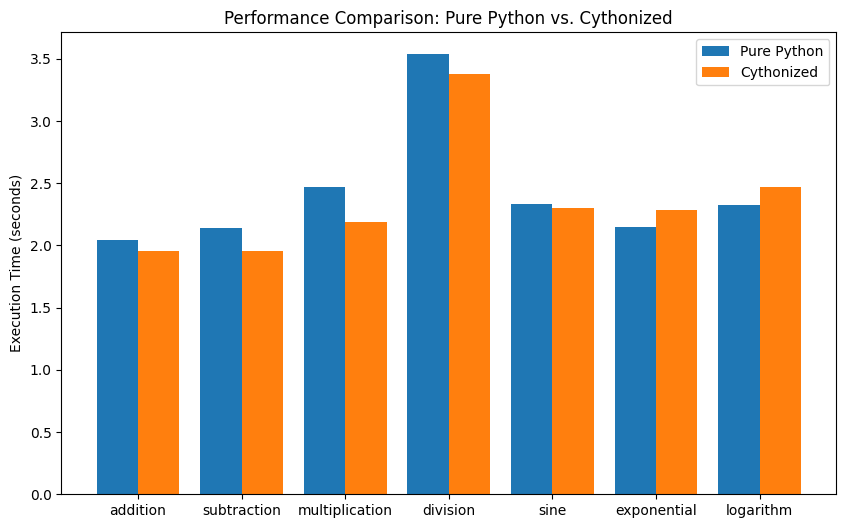

In [4]:
import time
import matplotlib.pyplot as plt
from dual_autodiff.dual import Dual as DualPython
from dual_autodiff_cython.dual import Dual as DualCython


# Define the benchmark function
def benchmark_operations(DualClass, iterations=100000):
    """
    Benchmark basic operations for a given Dual implementation.

    Args:
        DualClass (class): The Dual number class to benchmark.
        iterations (int): The number of iterations for the benchmark.

    Returns:
        dict: Execution times for different operations.
    """
    results = {}

    # Initialize dual numbers
    x = DualClass(3.0, 1.0)
    y = DualClass(2.0, 0.5)

    # Benchmark addition
    start_time = time.time()
    for _ in range(iterations):
        z = x + y
    results['addition'] = time.time() - start_time

    # Benchmark subtraction
    start_time = time.time()
    for _ in range(iterations):
        z = x - y
    results['subtraction'] = time.time() - start_time

    # Benchmark multiplication
    start_time = time.time()
    for _ in range(iterations):
        z = x * y
    results['multiplication'] = time.time() - start_time

    # Benchmark division
    start_time = time.time()
    for _ in range(iterations):
        z = x / y
    results['division'] = time.time() - start_time

    # Benchmark sine
    start_time = time.time()
    for _ in range(iterations):
        z = x.sin()
    results['sine'] = time.time() - start_time

    # Benchmark exponential
    start_time = time.time()
    for _ in range(iterations):
        z = x.exp()
    results['exponential'] = time.time() - start_time

    # Benchmark logarithm
    start_time = time.time()
    for _ in range(iterations):
        z = x.log()
    results['logarithm'] = time.time() - start_time

    return results

# Run benchmarks
iterations = 10000000
results_python = benchmark_operations(DualPython, iterations)
results_cython = benchmark_operations(DualCython, iterations)

# Compare results
print("Performance Results:")
print("Pure Python:", results_python)
print("Cythonized:", results_cython)

# Plot results
labels = list(results_python.keys())
python_times = [results_python[label] for label in labels]
cython_times = [results_cython[label] for label in labels]

x = range(len(labels))

plt.figure(figsize=(10, 6))
plt.bar(x, python_times, width=0.4, label="Pure Python", align='center')
plt.bar([i + 0.4 for i in x], cython_times, width=0.4, label="Cythonized", align='center')
plt.xticks([i + 0.2 for i in x], labels)
plt.ylabel("Execution Time (seconds)")
plt.title("Performance Comparison: Pure Python vs. Cythonized")
plt.legend()
plt.show()
